# Многослойный персептрон

# Итоговое задание №2. Прогнозирование конечных свойств новых материалов (композиционных материалов)
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. 

Предсказание (из семинара 22): 
* модуль упругости при растяжении
* прочности при растяжении
* cоотношение матрица-наполнитель

Предсказание (из итогового вебинара 26.11.2022):
* модуль упругости при растяжении
* прочности при растяжении

In [1]:
import numpy as np
import pandas as pd

In [2]:
# считывание данных из файла
def load_simple_df(full_nm_str):
    sdf = pd.read_csv('../data/interim/'+full_nm_str+'.csv', sep=';',index_col=0) # Загрузка и создание датафрейма из csv файла
    return sdf

#считывание всех наборов для одного из целевых показателей
def load_data(nm_str):
    x_train = load_simple_df('X_train_'+nm_str)
    y_train = load_simple_df('y_train_'+nm_str)
    x_test = load_simple_df('X_test_'+nm_str)
    y_test=load_simple_df('y_test_'+nm_str)
    x_val=load_simple_df('X_val_'+nm_str)
    y_val=load_simple_df('y_val_'+nm_str)
    return (x_train, y_train, x_test, y_test, x_val, y_val)

Многослойный персептрон

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [4]:
# тренировка модели Многослойного персептрона
def try_perseptron(x_train, y_train, x_val, y_val):
    mlpr_model = MLPRegressor(random_state=14)
    mlpr_model_params = { 'hidden_layer_sizes' : [(100, 100, 50, 25, 12), 
                                                  (144, 144, 72, 36, 12, 1), 
                                                  (12, 12, 12, 12, 12),
                                                  (144, 144, 144, 72, 72, 36, 36), 
                                                  ()],
                           'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                           'solver' : ['sgd', 'adam'],
                           'max_iter' : [100],
                           'learning_rate' : ['constant', 'adaptive', 'invscaling']
                        }
    
    GSCV_mlpr_model = GridSearchCV(mlpr_model, mlpr_model_params, n_jobs=-1, cv=10)   
    GSCV_mlpr_model.fit(x_train, y_train)
    mlpr_model_predict = GSCV_mlpr_model.best_estimator_
    mlpr_model_best_params = GSCV_mlpr_model.best_params_
    
    MSE = mean_squared_error(y_val, mlpr_model_predict.predict(x_val))
    R2 = r2_score(y_val, mlpr_model_predict.predict(x_val))

    return (MSE, R2, mlpr_model_predict, mlpr_model_best_params)

In [6]:
#запуск модели Персептрона и вычисление метрик
def fit_perseptron(nm_file_str, nm_error_df_str):
    #считываем данные из файлов
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_df = pd.DataFrame()
    x_val_df = pd.DataFrame()
    y_val_df = pd.DataFrame()

    (x_train_df, y_train_df, x_test_df, y_test_df, x_val_df, y_val_df) = load_data(nm_file_str)

    #обучаем модель
    (MSE, R2, prediction_y_perseptron, params_y_perseptron) = try_perseptron(x_train_df, y_train_df, x_val_df, y_val_df)
    perseptron_errors = pd.DataFrame({'model_name':'MLPRegressor',
                              'target_var':[nm_error_df_str],
                              'MSE':[MSE],
                              'R2':[R2]})
    return (perseptron_errors, x_val_df, y_val_df, prediction_y_perseptron, params_y_perseptron)

In [7]:
#визуализация
import matplotlib.pyplot as plt

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Валидационные и прогнозные значения: {model_name}')
    plt.plot(orig, label='Валидация')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

Для каждой характеристики запускаем последовательно обучение моделей

In [9]:
#датасет со значениями ошибок
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])

(fit_errors, x_val_elastic, y_val_elastic, y_elastic_predict, y_elastic_params_lasso) = fit_perseptron('elastic', 'Модуль упругости при растяжении, ГПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
(fit_errors, x_val_strength, y_val_strength, y_strength_predict, y_strength_params_lasso) = fit_perseptron('strength', 'Прочность при растяжении, МПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
(fit_errors, x_val_matrix, y_val_matrix, y_matrix_predict, y_matrix_params_lasso) = fit_perseptron('matrix', 'Соотношение матрица-наполнитель')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
errors_df

C:\Users\user\.virtualenvs\dsCompositeMaterialRepo-7MAGXAOR\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\.virtualenvs\dsCompositeMaterialRepo-7MAGXAOR\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\.virtualenvs\dsCompositeMaterialRepo-7MAGXAOR\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",MLPRegressor,0.028995,-0.010048
1,"Прочность при растяжении, МПа",MLPRegressor,0.031805,-0.046152
2,Соотношение матрица-наполнитель,MLPRegressor,0.027413,-0.000726


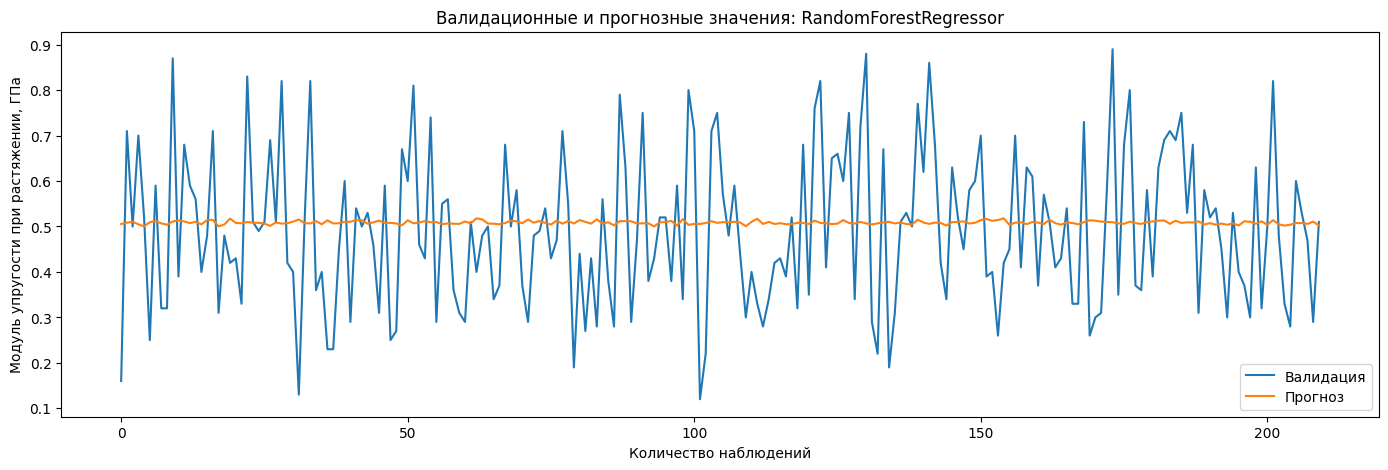

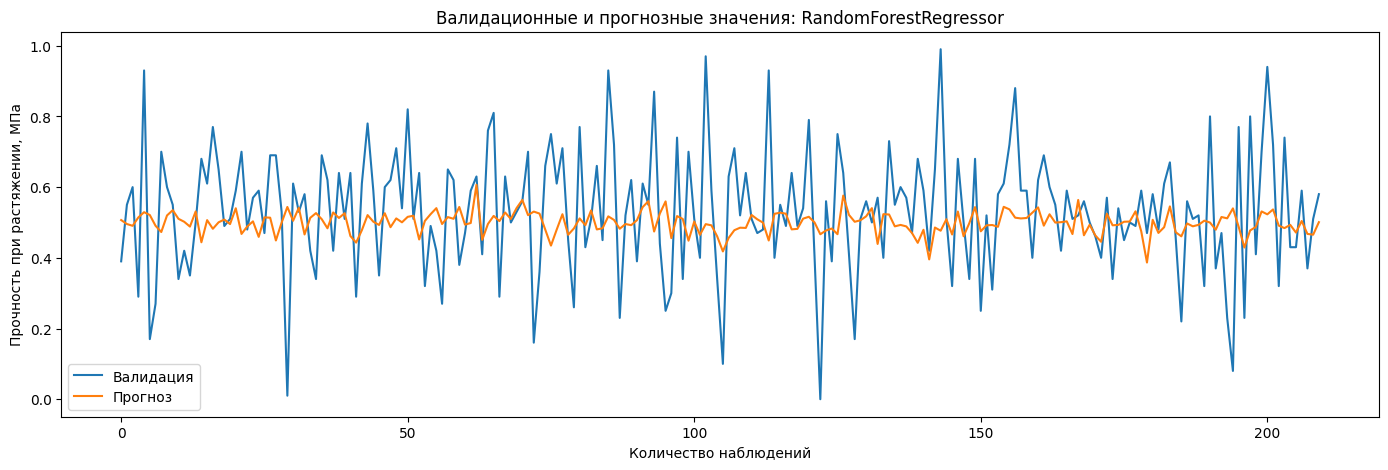

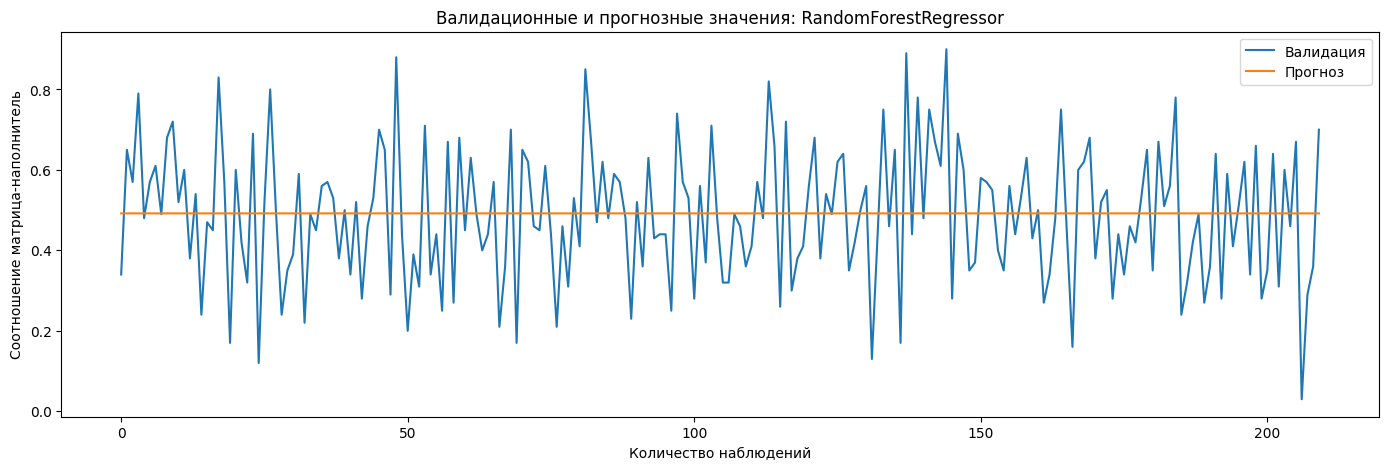

In [10]:
actual_and_predicted_plot(y_val_elastic.values,
                            y_elastic_predict.predict(x_val_elastic), 
                            'Модуль упругости при растяжении, ГПа',
                            'MLPRegressor')
actual_and_predicted_plot(y_val_strength.values,
                            y_strength_predict.predict(x_val_strength), 
                            'Прочность при растяжении, МПа', 
                            'MLPRegressor')
actual_and_predicted_plot(y_val_matrix.values,
                            y_matrix_predict.predict(x_val_matrix), 
                            'Соотношение матрица-наполнитель', 
                            'MLPRegressor')